# Stock Market Prediction using Multivariate LSTM Time Series

In [59]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Apple'
symbol = 'AAPL'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04 00:00:00-05:00,7.622,7.661,7.585,7.643,6.515,493729600
2010-01-05 00:00:00-05:00,7.664,7.700,7.616,7.656,6.526,601904800
2010-01-06 00:00:00-05:00,7.656,7.687,7.527,7.535,6.423,552160000
2010-01-07 00:00:00-05:00,7.562,7.571,7.466,7.521,6.411,477131200
2010-01-08 00:00:00-05:00,7.511,7.571,7.466,7.571,6.453,447610800


In [60]:
pd.options.display.float_format = '{:.3f}'.format

In [61]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04 00:00:00-05:00,7.622,7.661,7.585,7.643,6.515,493729600
2010-01-05 00:00:00-05:00,7.664,7.700,7.616,7.656,6.526,601904800
2010-01-06 00:00:00-05:00,7.656,7.687,7.527,7.535,6.423,552160000
2010-01-07 00:00:00-05:00,7.562,7.571,7.466,7.521,6.411,477131200
2010-01-08 00:00:00-05:00,7.511,7.571,7.466,7.571,6.453,447610800


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3258 entries, 2010-01-04 00:00:00-05:00 to 2022-12-09 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3258 non-null   float64
 1   High       3258 non-null   float64
 2   Low        3258 non-null   float64
 3   Close      3258 non-null   float64
 4   Adj Close  3258 non-null   float64
 5   Volume     3258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 178.2 KB


In [63]:
df.shape

(3258, 6)

 #### Aldığımız değişkenleri önce bir çizgi grafiği ile çizdiriyoruz.

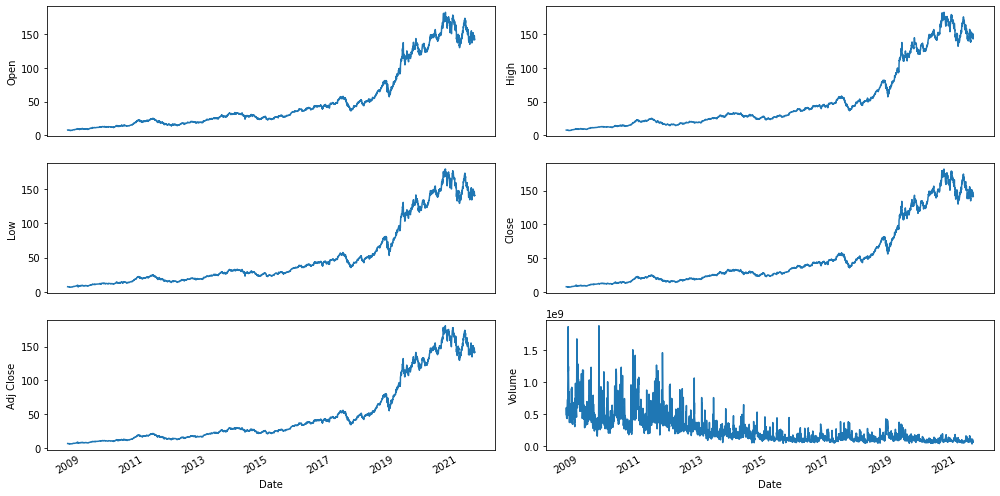

In [64]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### Bu değişkenleri 0-1 arasında ölçeklendirdiğimizde de aynı grafiğin ortaya çıkmasını bekliyoruz.MinMaxScaler ölçeklendirme işlemi tüm veri değerlerinden en küçük değeri çıkarıp daha sonra bu değerleri en yüksek ile en düşük değerin farkına bölerek uygulanır.

normalized_df=(df-df.min())/(df.max()-df.min())

normalized_df.head()

df_plot = normalized_df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### Burada sinir ağını eğiteceğimiz özelliklerimizi listeliyoruz ve tahmin edeceğimiz fiyatı kapanış fiyatı olarak belirliyoruz.

In [65]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2022-12-05 00:00:00-05:00,150.920,145.770,147.770,146.630,68826400,146.630
2022-12-06 00:00:00-05:00,147.300,141.920,147.070,142.910,64727200,142.910
2022-12-07 00:00:00-05:00,143.370,140.000,142.190,140.940,69721100,140.940
2022-12-08 00:00:00-05:00,143.520,141.100,142.360,142.650,62128300,142.650
2022-12-09 00:00:00-05:00,145.570,140.900,142.340,142.160,76069500,142.160


In [66]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2022-12-05 00:00:00-05:00,150.920,145.770,147.770,146.630,68826400
2022-12-06 00:00:00-05:00,147.300,141.920,147.070,142.910,64727200
2022-12-07 00:00:00-05:00,143.370,140.000,142.190,140.940,69721100
2022-12-08 00:00:00-05:00,143.520,141.100,142.360,142.650,62128300
2022-12-09 00:00:00-05:00,145.570,140.900,142.340,142.160,76069500


## Sor

data_filtered = data_filtered.drop("Close",axis = 1)

In [67]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2022-12-05 00:00:00-05:00,150.920,145.770,147.770,146.630,68826400
2022-12-06 00:00:00-05:00,147.300,141.920,147.070,142.910,64727200
2022-12-07 00:00:00-05:00,143.370,140.000,142.190,140.940,69721100
2022-12-08 00:00:00-05:00,143.520,141.100,142.360,142.650,62128300
2022-12-09 00:00:00-05:00,145.570,140.900,142.340,142.160,76069500


#### Burada girdi verilerini numpy formatına dönüştürüp 0-1 arasında MinMaxScaler ile ölçeklendiriyoruz.Bu ölçeklendirdiğimiz veriler eğitildiğinde sonuçlar da ölçeklenmiş şekilde gelecektir bunu geri dönüştürmeyi unutmamalıyız.

In [68]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3258, 5)


In [76]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [77]:
np_data[1]

array([7.700e+00, 7.616e+00, 7.664e+00, 7.656e+00, 6.019e+08])

In [78]:
np_data_scaled[0]

array([0.004, 0.005, 0.004, 0.004, 0.248])

In [79]:
np_Close_scaled[0]

array([0.004])

#### Çok değişkenli modelimizi üç boyutlu veri yapısına yönelik eğitiyoruz.
#### Birinci : Sequences(Diziler)
#### İkinci : Time Steps(Mini-Batches)
#### Üçüncü : Features(Özellikler)
#### Birincil hedefimiz verileri ilişkili hedef girdi değerleriyle birden çok girdi veri dizisine dilimlemektir. Kayan pencere kullanımı sağlayan bir python kodu yazıyoruz. Bu yaklaşım, her adımda girdi verilerine birden çok veri noktası dizisi ekleyerek bir pencereyi zaman serisi verileri arasında hareket ettirir. Hedef değer (örn. Kapanış Fiyatı) bu sırayı takip eder ve biz onu ayrı bir hedef veri setinde saklarız. Ardından pencereyi bir adım daha ileri iterek bu etkinlikleri tekrarlıyoruz. Bu işlem, her biri hedef kayıtta karşılık gelen bir hedef değere sahip birçok giriş dizisine (mini yığınlar) sahip bir veri seti ile sonuçlanır. Bu süreç hem eğitim hem de test verileri için geçerlidir.
#### Sonuç olarak her biri 5 özellik içeren 2535 train verimiz oluyor.

In [80]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2557, 50, 5) (2557,)
(651, 50, 5) (651,)
0.0065392502913691475
0.0065392502913691475


#### Sinir ağımızın mimarisi aşağıdaki dört katmandan oluşur:
#### Mini gruplarımızı girdi olarak alan ve tüm diziyi döndüren bir LSTM katmanı
#### Diziyi önceki katmandan alan ancak yalnızca beş değer döndüren başka bir LSTM katmanı
#### Beş nöronlu yoğun katman
#### Öngörülen değeri veren son yoğun katman
#### İlk katmandaki nöronların sayısı, girdi verilerinin bir mini partisinin boyutuna eşit olmalıdır. Veri kümemizdeki her mini parti, 50 adım ve beş özellik içeren bir matristen oluşur. Böylece, tekrarlayan sinir ağımızın giriş katmanı 250 nörondan oluşur. Bu mimariyi akılda tutmak önemlidir çünkü daha sonra yeni bir veri kümesini tahmin etmek istediğimizde verileri aynı şekle getirmemiz gerekir. Aşağıdaki kodu çalıştırmak model mimarisini oluşturur ve modeli derler.

In [81]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 

model.add(LSTM(n_neurons, return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

250 50 5


In [82]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [83]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
160/160 [==============================] - 20s 102ms/step - loss: 3.7525e-04 - val_loss: 0.0012
Epoch 2/50
160/160 [==============================] - 15s 96ms/step - loss: 5.8356e-05 - val_loss: 8.1175e-04
Epoch 3/50
160/160 [==============================] - 15s 94ms/step - loss: 5.1973e-05 - val_loss: 8.6644e-04
Epoch 4/50
160/160 [==============================] - 15s 92ms/step - loss: 4.7725e-05 - val_loss: 0.0020
Epoch 5/50
160/160 [==============================] - 15s 95ms/step - loss: 5.5897e-05 - val_loss: 0.0013
Epoch 6/50
160/160 [==============================] - 15s 94ms/step - loss: 6.0643e-05 - val_loss: 0.0014
Epoch 7/50
160/160 [==============================] - 16s 97ms/step - loss: 3.8274e-05 - val_loss: 7.9688e-04
Epoch 8/50
160/160 [==============================] - 16s 98ms/step - loss: 3.9139e-05 - val_loss: 4.9752e-04
Epoch 9/50
160/160 [==============================] - 16s 98ms/step - loss: 3.5711e-05 - val_loss: 5.8032e-04
Epoch 10/50
160/160 [====

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

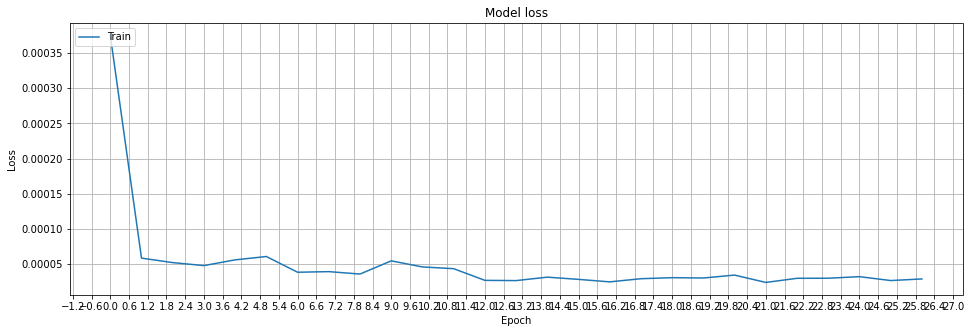

In [84]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [85]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 2s 70ms/step
Median Absolute Error (MAE): 3.02
Mean Absolute Percentage Error (MAPE): 2.18 %
Median Absolute Percentage Error (MDAPE): 1.86 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

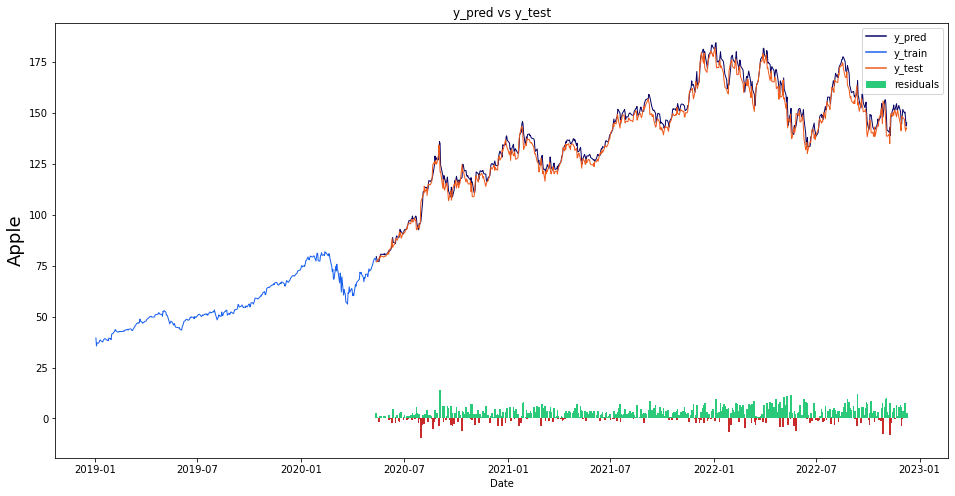

In [86]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [87]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 29ms/step
The close price for Apple at 2022-12-10 was 142.16
The predicted close price is 145.42999267578125 (+2.25%)


## WindowSize Update

In [88]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2543, 64, 5) (2543,)
(651, 64, 5) (651,)
0.009899615512598041
0.009899615512598041


In [89]:
train_data.shape

(2607, 5)

In [90]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(n_neurons,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64, 320)           417280    
                                                                 
 lstm_3 (LSTM)               (None, 320)               820480    
                                                                 
 dense_2 (Dense)             (None, 5)                 1605      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,239,371
Trainable params: 1,239,371
Non-trainable params: 0
_________________________________________________________________


In [91]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [93]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
80/80 [==============================] - 31s 385ms/step - loss: 3.5988e-04 - val_loss: 0.0011
Epoch 2/50
80/80 [==============================] - 30s 377ms/step - loss: 6.3368e-05 - val_loss: 0.0010
Epoch 3/50
80/80 [==============================] - 29s 369ms/step - loss: 5.6715e-05 - val_loss: 0.0011
Epoch 4/50
80/80 [==============================] - 31s 387ms/step - loss: 5.0789e-05 - val_loss: 8.3318e-04
Epoch 5/50
80/80 [==============================] - 31s 388ms/step - loss: 4.9062e-05 - val_loss: 0.0023
Epoch 6/50
80/80 [==============================] - 31s 386ms/step - loss: 5.6761e-05 - val_loss: 8.8094e-04
Epoch 7/50
80/80 [==============================] - 31s 387ms/step - loss: 4.9276e-05 - val_loss: 7.6959e-04
Epoch 8/50
80/80 [==============================] - 31s 388ms/step - loss: 4.3507e-05 - val_loss: 7.0188e-04
Epoch 9/50
80/80 [==============================] - 30s 374ms/step - loss: 3.8700e-05 - val_loss: 7.1225e-04
Epoch 10/50
80/80 [================

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

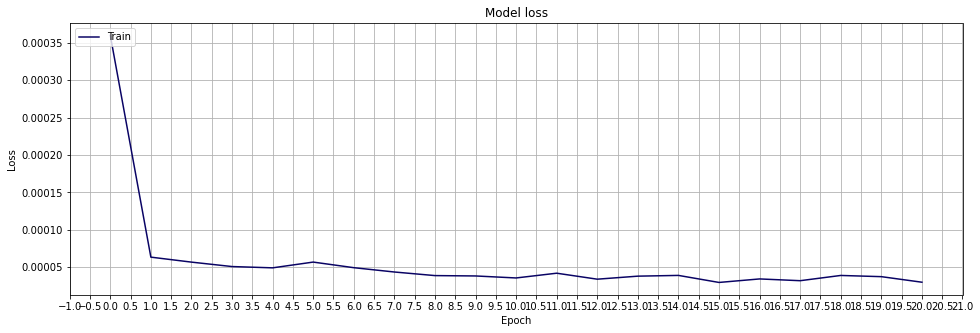

In [94]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [95]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 3s 125ms/step
Median Absolute Error (MAE): 4.6
Mean Absolute Percentage Error (MAPE): 3.28 %
Median Absolute Percentage Error (MDAPE): 2.78 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

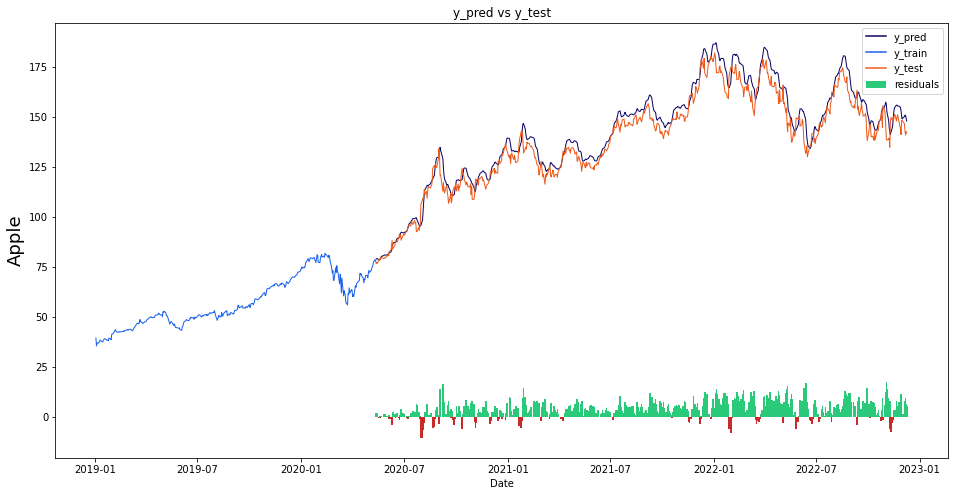

In [96]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [97]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 39ms/step
The close price for Apple at 2022-12-10 was 142.16
The predicted close price is 147.13999938964844 (+3.38%)


## https://www.researchgate.net/profile/Murtaza-Roondiwala/publication/327967988_Predicting_Stock_Prices_Using_LSTM/links/5bafbe6692851ca9ed30ceb9/Predicting-Stock-Prices-Using-LSTM.pdf

In [46]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64, 128)           68608     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 119,073
Trainable params: 119,073
Non-trainable params: 0
_________________________________________________________________


In [47]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [48]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
159/159 [==============================] - 11s 49ms/step - loss: 3.7844e-04 - val_loss: 0.0011
Epoch 2/50
159/159 [==============================] - 7s 44ms/step - loss: 7.5378e-05 - val_loss: 0.0019
Epoch 3/50
159/159 [==============================] - 7s 45ms/step - loss: 7.0646e-05 - val_loss: 9.7542e-04
Epoch 4/50
159/159 [==============================] - 7s 43ms/step - loss: 5.6286e-05 - val_loss: 9.5439e-04
Epoch 5/50
159/159 [==============================] - 7s 46ms/step - loss: 5.2623e-05 - val_loss: 7.2473e-04
Epoch 6/50
159/159 [==============================] - 7s 44ms/step - loss: 5.4850e-05 - val_loss: 7.2692e-04
Epoch 7/50
159/159 [==============================] - 7s 45ms/step - loss: 4.4780e-05 - val_loss: 0.0012
Epoch 8/50
159/159 [==============================] - 7s 45ms/step - loss: 5.3587e-05 - val_loss: 6.3217e-04
Epoch 9/50
159/159 [==============================] - 7s 45ms/step - loss: 4.4953e-05 - val_loss: 0.0015
Epoch 10/50
159/159 [=============

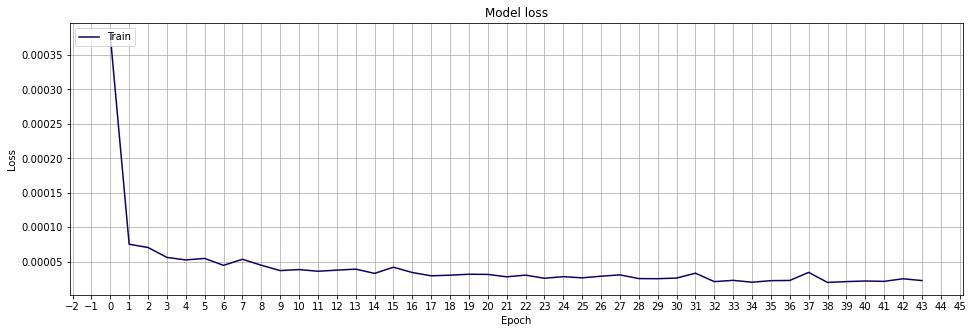

In [49]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [50]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 2s 27ms/step
Median Absolute Error (MAE): 5.68
Mean Absolute Percentage Error (MAPE): 4.0 %
Median Absolute Percentage Error (MDAPE): 3.9 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

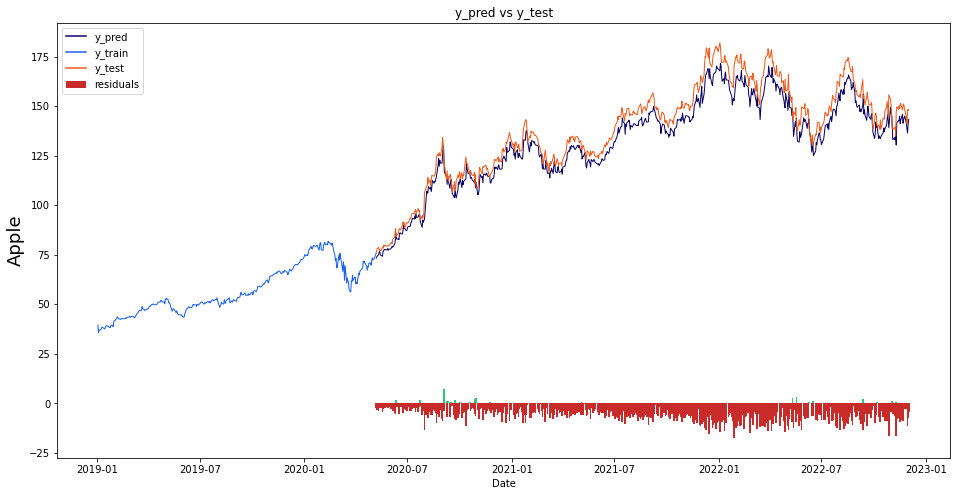

In [51]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [52]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 23ms/step
The close price for Apple at 2022-12-05 was 147.81
The predicted close price is 140.58999633789062 (-5.14%)


## https://python.plainenglish.io/predicting-apple-stock-price-36f329cda530

In [53]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2553, 50, 5) (2553,)
(650, 50, 5) (650,)
0.0065392502913691475
0.0065392502913691475


In [54]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dropout(0.1))

model.add(LSTM(n_neurons))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

250 50 5
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 250)           256000    
                                                                 
 dropout (Dropout)           (None, 50, 250)           0         
                                                                 
 lstm_11 (LSTM)              (None, 250)               501000    
                                                                 
 dense_8 (Dense)             (None, 5)                 1255      
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 758,261
Trainable params: 758,261
Non-trainable params: 0
_________________________________________________________________


In [55]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [56]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
160/160 [==============================] - 20s 102ms/step - loss: 3.8684e-04 - val_loss: 9.2823e-04
Epoch 2/50
160/160 [==============================] - 16s 99ms/step - loss: 8.2470e-05 - val_loss: 7.5353e-04
Epoch 3/50
160/160 [==============================] - 16s 99ms/step - loss: 5.7912e-05 - val_loss: 9.9461e-04
Epoch 4/50
160/160 [==============================] - 16s 101ms/step - loss: 6.0331e-05 - val_loss: 9.2974e-04
Epoch 5/50
160/160 [==============================] - 16s 99ms/step - loss: 5.2084e-05 - val_loss: 6.5224e-04
Epoch 6/50
160/160 [==============================] - 16s 99ms/step - loss: 4.9311e-05 - val_loss: 8.1905e-04
Epoch 7/50
160/160 [==============================] - 16s 101ms/step - loss: 4.3629e-05 - val_loss: 6.9624e-04
Epoch 8/50
160/160 [==============================] - 17s 104ms/step - loss: 6.3896e-05 - val_loss: 0.0011
Epoch 9/50
160/160 [==============================] - 17s 104ms/step - loss: 4.3907e-05 - val_loss: 4.8991e-04
Epoch 10/

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

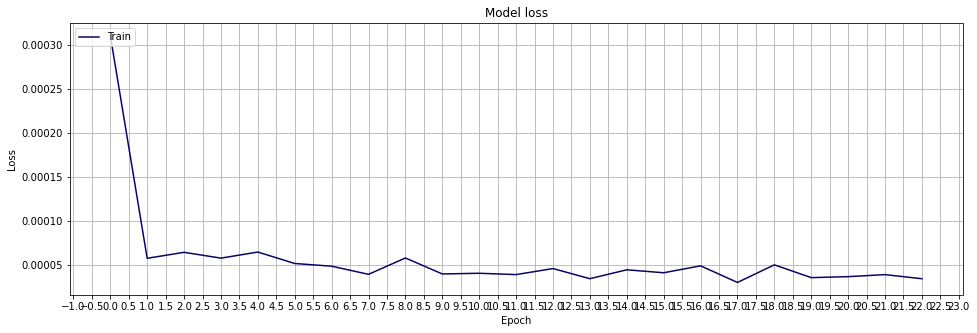

In [25]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [26]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 2s 62ms/step
Median Absolute Error (MAE): 6.08
Mean Absolute Percentage Error (MAPE): 4.4 %
Median Absolute Percentage Error (MDAPE): 4.41 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

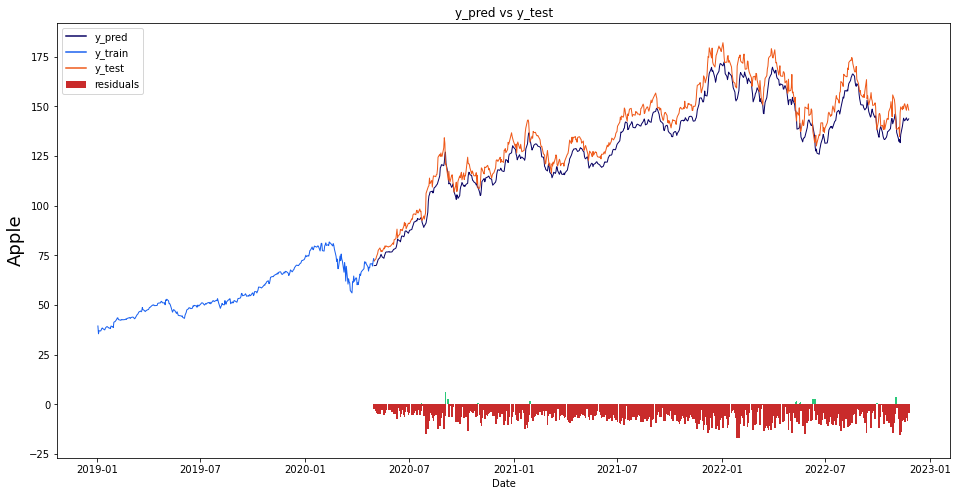

In [27]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [28]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 25ms/step
The close price for Apple at 2022-11-28 was 148.11
The predicted close price is 142.60000610351562 (-3.86%)


## https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/

In [14]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2549, 50, 5) (2549,)
(649, 50, 5) (649,)
0.0065392502913691475
0.0065392502913691475


In [29]:
model=Sequential()
model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(n_neurons,return_sequences=True))

model.add(LSTM(n_neurons))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_5 (LSTM)               (None, 50, 250)           501000    
                                                                 
 lstm_6 (LSTM)               (None, 250)               501000    
                                                                 
 dense_4 (Dense)             (None, 5)                 1255      
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,259,261
Trainable params: 1,259,261
Non-trainable params: 0
_________________________________________________________________


In [30]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [31]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
160/160 [==============================] - 60s 345ms/step - loss: 9.9939e-04 - val_loss: 0.0025
Epoch 2/50
160/160 [==============================] - 45s 284ms/step - loss: 1.1180e-04 - val_loss: 0.0012
Epoch 3/50
160/160 [==============================] - 48s 298ms/step - loss: 9.4765e-05 - val_loss: 0.0012
Epoch 4/50
160/160 [==============================] - 49s 306ms/step - loss: 6.1195e-05 - val_loss: 0.0014
Epoch 5/50
160/160 [==============================] - 50s 311ms/step - loss: 8.1028e-05 - val_loss: 0.0021
Epoch 6/50
160/160 [==============================] - 48s 301ms/step - loss: 5.1259e-05 - val_loss: 0.0011
Epoch 7/50
160/160 [==============================] - 50s 310ms/step - loss: 6.8055e-05 - val_loss: 0.0010
Epoch 8/50
160/160 [==============================] - 48s 299ms/step - loss: 4.9726e-05 - val_loss: 7.0549e-04
Epoch 9/50
160/160 [==============================] - 50s 314ms/step - loss: 7.2548e-05 - val_loss: 9.6311e-04
Epoch 10/50
160/160 [========

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

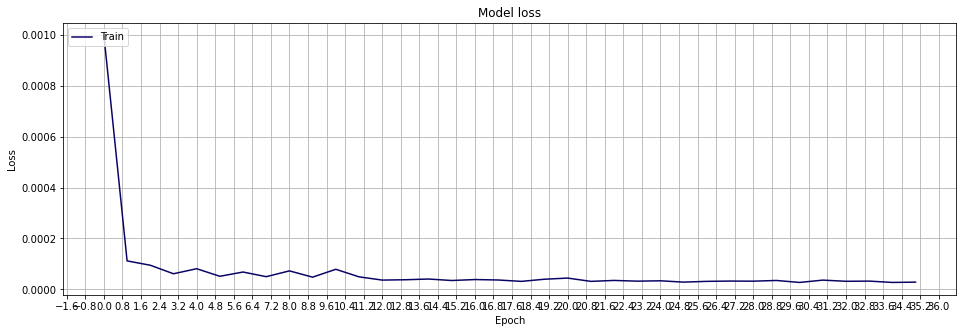

In [32]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [33]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 4s 117ms/step
Median Absolute Error (MAE): 2.9
Mean Absolute Percentage Error (MAPE): 2.09 %
Median Absolute Percentage Error (MDAPE): 1.8 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

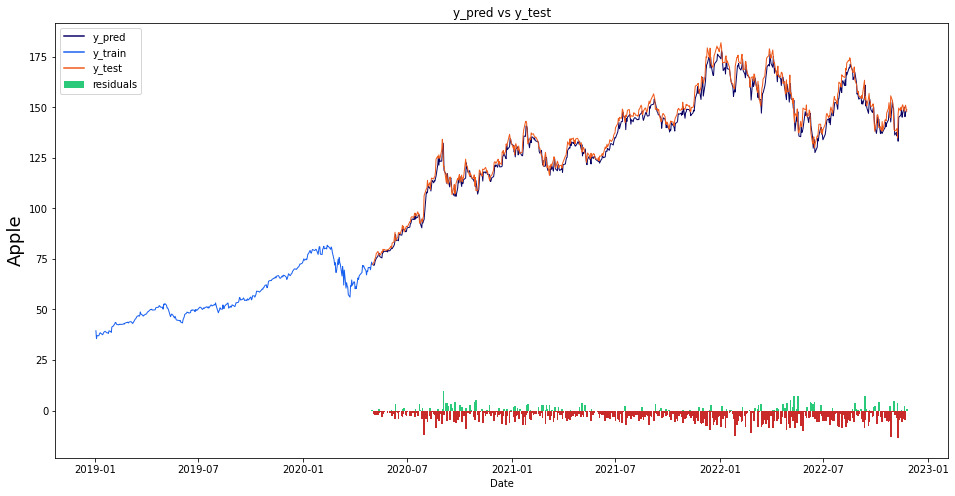

In [34]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [51]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 31ms/step
The close price for Apple at 2022-11-15 was 148.28
The predicted close price is 147.80999755859375 (-0.32%)


## https://www.youtube.com/watch?v=gSYiKKoREFI

In [14]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2549, 50, 5) (2549,)
(649, 50, 5) (649,)
0.0065392502913691475
0.0065392502913691475


In [19]:
from keras.optimizers import Adam

In [20]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]

model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=n_neurons, return_sequences=False))

model.add(Dropout(0.25))

model.add(Dense(units=5, activation='relu'))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_5 (LSTM)               (None, 250)               501000    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 757,251
Trainable params: 757,251
Non-trainable params: 0
_________________________________________________________________


In [21]:
callbacks = EarlyStopping(monitor = "loss",patience = 5,verbose = 1)

In [22]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
160/160 [==============================] - 18s 93ms/step - loss: 0.0710 - val_loss: 0.2932
Epoch 2/50
160/160 [==============================] - 16s 97ms/step - loss: 0.0022 - val_loss: 0.0468
Epoch 3/50
160/160 [==============================] - 16s 99ms/step - loss: 0.0037 - val_loss: 0.0090
Epoch 4/50
160/160 [==============================] - 16s 99ms/step - loss: 4.9598e-04 - val_loss: 0.0171
Epoch 5/50
160/160 [==============================] - 14s 89ms/step - loss: 3.7936e-04 - val_loss: 0.0196
Epoch 6/50
160/160 [==============================] - 14s 89ms/step - loss: 3.6098e-04 - val_loss: 0.0171
Epoch 7/50
160/160 [==============================] - 15s 95ms/step - loss: 2.8007e-04 - val_loss: 0.0158
Epoch 8/50
160/160 [==============================] - 16s 97ms/step - loss: 2.4366e-04 - val_loss: 0.0104
Epoch 9/50
160/160 [==============================] - 16s 98ms/step - loss: 2.1838e-04 - val_loss: 0.0086
Epoch 10/50
160/160 [==============================] - 15s

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

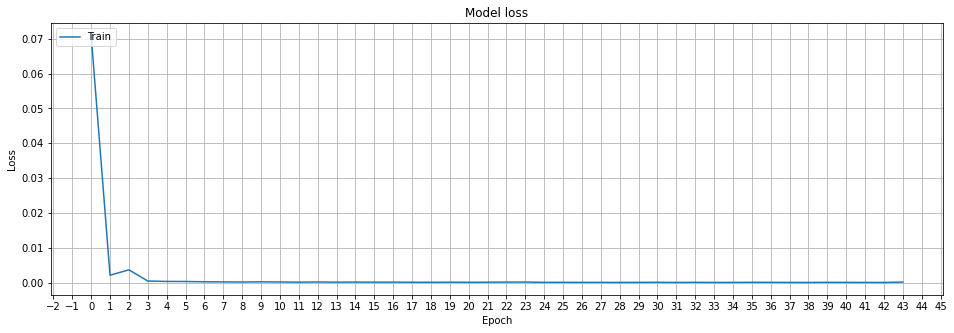

In [23]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [24]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

21/21 [==============================] - 2s 64ms/step
Median Absolute Error (MAE): 24.32
Mean Absolute Percentage Error (MAPE): 16.47 %
Median Absolute Percentage Error (MDAPE): 17.27 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

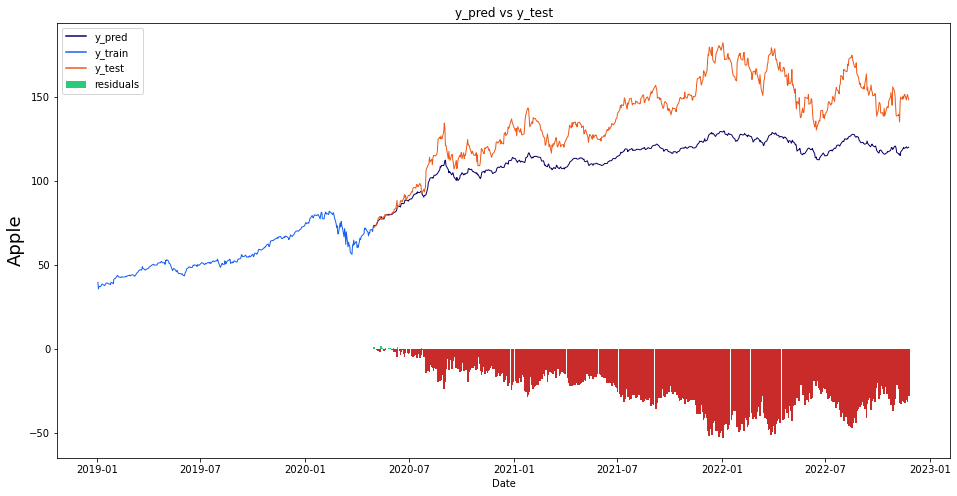

In [25]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [26]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 25ms/step
The close price for Apple at 2022-11-28 was 148.11
The predicted close price is 119.19000244140625 (-24.26%)
